In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


/home/vimarsh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

class NpyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the .npy image files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Collect all .npy files and their labels based on folder names.
        self.image_paths = []
        self.labels = []
        class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        print("Found classes:", class_dirs)
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_dirs)}
        for class_name in class_dirs:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for file_path in glob.glob(os.path.join(class_path, '*.npy')):
                self.image_paths.append(file_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        image = torch.from_numpy(image).float()  # Expecting shape (1, H, W)
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Adjust these paths as needed
train_dir = "/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/train"
val_dir = "/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/val"

# Simple transformation: here we assume the .npy images are already normalized
transform = transforms.Compose([
    # Uncomment if you wish to apply additional transforms
    # transforms.Resize((150,150)),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and dataloaders
train_dataset = NpyImageDataset(train_dir, transform=transform)
val_dataset = NpyImageDataset(val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


Found classes: ['no', 'vort', 'sphere']
Found classes: ['no', 'vort', 'sphere']


In [4]:
def deltamat(shape):
    kk = np.zeros((shape, shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = np.sqrt((i+1)**2 + (j+1)**2)
    return torch.tensor(kk, dtype=torch.float32)

# Create a positional matrix for images of size 150x150
pos_matrix = deltamat(150).unsqueeze(0).to("cuda")



In [5]:


from torchvision.models import resnet18, resnet34
from itertools import cycle
from sklearn.metrics import auc
class LensPINN(nn.Module):
    def __init__(self, pos_mat):
        super(LensPINN, self).__init__()
        self.pos_mat = pos_mat  # (1,150,150)
        
        # Encoder: feature extractor from a grayscale image using a resnet18 backbone.
        # self.encoder = timm.create_model("resnet18", pretrained=True, drop_rate=0.1)
        self.encoder = resnet18(pretrained=False)
        # Adjust first convolution to accept 1 channel
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Change final FC to output an image-sized vector (150x150)
        self.encoder.fc = nn.Linear(512, 150*150, bias=True)
        
        # Physics Branch: predicts 3 parameters (theta_E, gamma, phi)
        # self.physics_branch = timm.create_model("resnet18", pretrained=True, drop_rate=0.1)
        self.physics_branch = resnet18(pretrained=False)
        # Modify input to 2 channels (concatenated original and physics-informed image)
        self.physics_branch.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.physics_branch.fc = nn.Linear(512, 3, bias=True)
    
    def generate_coord_grid(self, H, W, device):
        xs = torch.linspace(-1, 1, W, device=device)
        ys = torch.linspace(-1, 1, H, device=device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        grid = torch.stack([grid_x, grid_y], dim=0)  # shape: (2,H,W)
        return grid.unsqueeze(0)  # shape: (1,2,H,W)
    
    def lensing_equation(self, coord, theta_E, gamma, phi):
        """
        Complex gravitational lensing equation:
            beta = theta - theta_E*(theta/|theta|) - gamma * A(phi)*theta,
        where A(phi) = [[cos(2phi), sin(2phi)], [sin(2phi), -cos(2phi)]]
        coord: (batch,2,H,W)
        theta_E, gamma, phi: each of shape (batch,)
        """
        eps = 1e-6
        batch = coord.size(0)
        theta_E = theta_E.view(batch, 1, 1, 1)
        gamma   = gamma.view(batch, 1, 1, 1)
        phi     = phi.view(batch, 1, 1, 1)
        # Compute unit vector in direction of theta (pixel coordinate)
        norm = torch.sqrt(coord[:,0:1,:,:]**2 + coord[:,1:2,:,:]**2 + eps)
        unit_coord = coord / norm
        
        # SIS deflection
        defl_SIS = theta_E * unit_coord
        
        # External shear deflection via shear matrix A(phi)
        cos2phi = torch.cos(2*phi)
        sin2phi = torch.sin(2*phi)
        theta_x = coord[:,0:1,:,:]
        theta_y = coord[:,1:2,:,:]
        shear_x = cos2phi * theta_x + sin2phi * theta_y
        shear_y = sin2phi * theta_x - cos2phi * theta_y
        defl_shear = gamma * torch.cat([shear_x, shear_y], dim=1)
        
        beta_pred = coord - defl_SIS - defl_shear
        return beta_pred
    
    def forward(self, x):
        # x: (batch,1,150,150)
        batch = x.size(0)
        # Use encoder to obtain an angular distortion map
        enc_out = self.encoder(x)              # shape: (batch,150*150)
        enc_out = enc_out.view(batch, 1, 150, 150)  # reshape to (batch,1,150,150)
        ang_dist = enc_out * self.pos_mat      # element-wise multiplication
        
        # Compute a preliminary source image using a simple subtraction
        src_img = x - ang_dist                 # shape: (batch,1,150,150)
        # Concatenate the original and source images to form 2-channel input
        two_chan = torch.cat([x, src_img], dim=1)  # shape: (batch,2,150,150)
        
        # Get physics parameters: they serve as classification logits as well.
        params = self.physics_branch(two_chan)  # shape: (batch,3)
        # For physics equation, we interpret params as [theta_E, gamma, phi]
        theta_E = params[:,0]
        gamma   = params[:,1]
        phi     = params[:,2]
        
        # Generate a coordinate grid (normalized between -1 and 1)
        coord_grid = self.generate_coord_grid(150, 150, x.device)  # (1,2,150,150)
        coord_grid = coord_grid.repeat(batch, 1, 1, 1)  # (batch,2,150,150)
        
        # Compute the predicted source position using the complex lensing equation
        beta_pred = self.lensing_equation(coord_grid, theta_E, gamma, phi)
        
        # Return both the predicted parameters (used for classification) and beta_pred for physics loss.
        return params, beta_pred

In [6]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_samples = 0
    physics_loss_fn = nn.MSELoss()
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(device)          # shape: (batch,1,150,150)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass returns classification logits (params) and physics prediction beta_pred.
        params, beta_pred = model(imgs)
        # Classification loss: use cross entropy on params (3 classes)
        loss_cls = criterion(F.log_softmax(params, dim=1), labels)
        # Physics loss: assume target source position is centered (all zeros)
        beta_target = torch.zeros_like(beta_pred).to(device)
        loss_phys = physics_loss_fn(beta_pred, beta_target)
        loss = loss_cls + 0.3 * loss_phys
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)
    return total_loss / total_samples

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct = 0
    y_true = []
    y_scores = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            params, beta_pred = model(imgs)
            loss_cls = criterion(F.log_softmax(params, dim=1), labels)
            total_loss += loss_cls.item() * imgs.size(0)
            total_samples += imgs.size(0)
            preds = torch.argmax(F.log_softmax(params, dim=1), dim=1)
            correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(F.softmax(params, dim=1).cpu().numpy())
    acc = correct / total_samples
    avg_loss = total_loss / total_samples
    print(f"Val Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")
    
    # ROC AUC for each class
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    num_classes = y_scores.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # For all classes
    for i in range(num_classes):
        y_true_class = (y_true == i).astype(int)
        y_score_class = y_scores[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score_class)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average calculation
    y_true_flat = np.eye(num_classes)[y_true].ravel()
    y_score_flat = y_scores.ravel()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flat, y_score_flat)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotting ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle='-', linewidth=2)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    class_names = ['No Substructure', 'Subhalo', 'Vortex']

    for i, color, class_name in zip(range(num_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, linestyle='-', linewidth=2,
                 label=f'ROC for {class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # return fpr, tpr, roc_auc
    
    return avg_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LensPINN(pos_matrix).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=15, steps_per_epoch=steps_per_epoch,
                         pct_start=0.1, anneal_strategy="cos", final_div_factor=100)

#some other optimizer and schedular
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

train_losses = []
val_losses = []
best_val = np.inf

num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss
        }, "./Bestmodel.model")
        print("Best model saved!")
    print("-"*60)


/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50


Training:   0%|          | 0/235 [00:00<?, ?it/s]

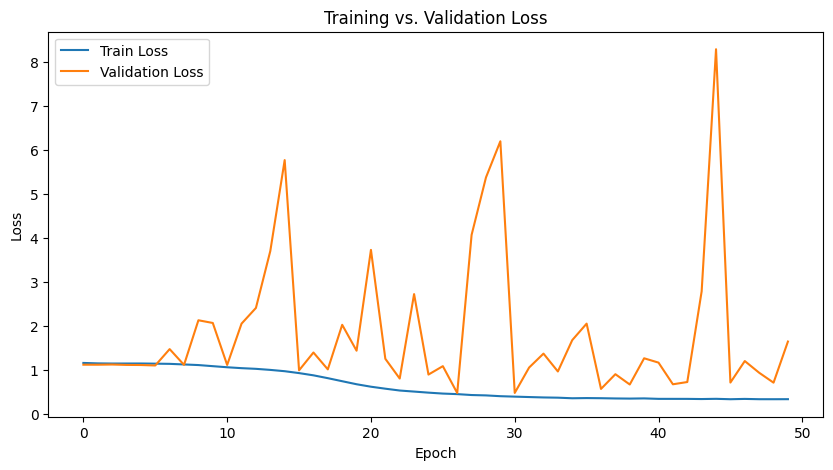

In [22]:
#plotting results and all
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()